In [1]:
from fipy import CellVariable, FaceVariable, Grid2D, Viewer, TransientTerm, DiffusionTerm, ImplicitSourceTerm
from fipy.tools import numerix
from builtins import range
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import deepxde as dde  

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [14]:
D = 1
L = 1
nx = 128
ny = nx
dx = 1 / nx
dy = dx
timeStepDuration = 5e-3
steps = 200
TOL = 1e-9
Maxiter = 1000
mesh = Grid2D(dx=dx, dy=dy, nx=nx, ny=ny)
# 16384 = 128*128, 33024 = 128*129*2

In [21]:
# 初值条件函数g
x, y = mesh.cellCenters
## Case 1:
##initial_1T = 0.001
## Case 2:
initial_1T = 0.001 + 100 * numerix.exp(-(x**2 + y**2)/0.01)

var_1T = CellVariable(mesh = mesh, value = initial_1T)

In [23]:
X, Y =mesh.faceCenters
# 电离度函数z
## Case 1:
##z = CellVariable(mesh = mesh, value = 1.)
##z.faceValue.constrain(10., where=(X<7/16) & (X>3/16) & (Y<13/16) & (Y>9/16))
##z.faceValue.constrain(10., where=(X<13/16) & (X>9/16) & (Y<7/16) & (Y>3/16))
## Case 2:
##z = CellVariable(mesh = mesh, value = 1.)
##z.faceValue.constrain(10., where=(X < 1/2))
## Case 3:
z = CellVariable(mesh = mesh, value = 1.)

face_z = z.faceValue

In [24]:
MA = numerix.MA

tmp = MA.repeat(mesh._faceCenters[..., numerix.NewAxis,:], 2, 1)
cellToFaceDistanceVectors = tmp - numerix.take(mesh._cellCenters, mesh.faceCellIDs, axis=1)

tmp = numerix.take(mesh._cellCenters, mesh.faceCellIDs, axis=1)
tmp = tmp[..., 1,:] - tmp[..., 0,:]
cellDistanceVectors = MA.filled(MA.where(MA.getmaskarray(tmp), cellToFaceDistanceVectors[:, 0], tmp))

mask = mesh.exteriorFaces
mask_boundary = mesh.facesLeft
dPf = FaceVariable(mesh=mesh,
                   value=-mesh._faceToCellDistanceRatio * cellDistanceVectors)
n = FaceVariable(mesh=mesh, value=mesh.faceNormals)
a = FaceVariable(mesh=mesh, value=0.5, rank=1)

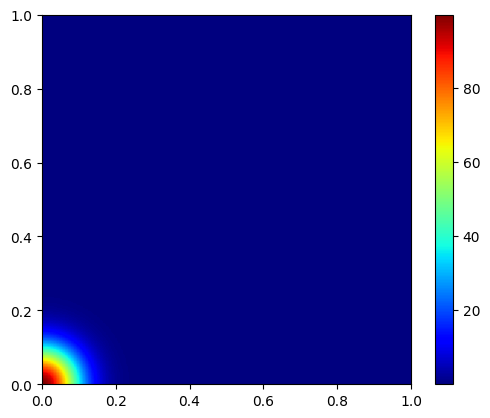

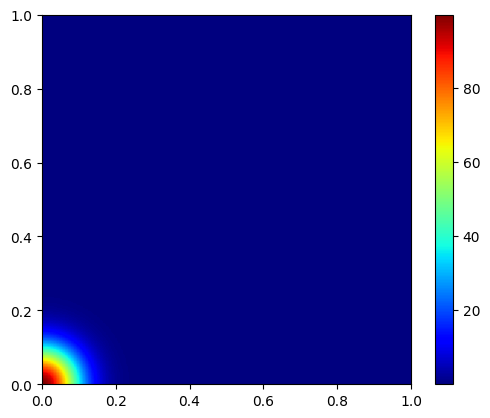

In [25]:
if __name__ == '__main__':
    viewer = Viewer(vars=var_1T)
    viewer.plot()

In [ ]:
var_inter = CellVariable(mesh=mesh, value=var_1T.value)
for t in np.arange(0, 1+timeStepDuration, timeStepDuration):
    initial_old = var_1T.value
    for inter in range(Maxiter):
        var_1T = CellVariable(mesh = mesh, value = initial_old)
        
        # 扩散系数D
        face_var = var_inter.faceValue
        theta = (face_z ** 3) / ((face_var ** (3/4)))
        ## 不限流
        ##theta = 3 * theta
        ##D_UL = 1 / theta()
        ## 限流
        grad_var = 3 * theta + var_inter.faceGrad.mag / face_var
        D_L = 1 / grad_var

        # 边值函数beta
        ## Case 1:
        beta = 0.
        ## Case 2:
        ##if t in np.arange(0, 0.5, 5e-3):
        ##    beta = 20 * t
        ##else:
        ##    beta = 10

        Gamma = FaceVariable(mesh=mesh, value=D_L)
        Gamma.setValue(0., where=mask)
        b = FaceVariable(mesh=mesh, value=D_L, rank=0)
        g = FaceVariable(mesh=mesh, value=0., rank=0)
        g.setValue(beta, where=mask_boundary)
        RobinCoeff = (mask * D_L * n / (-dPf.dot(n.dot(a)) + b))
        eq_1T = (TransientTerm() == DiffusionTerm(coeff=Gamma) + (RobinCoeff * g).divergence
            - ImplicitSourceTerm(coeff=(RobinCoeff.dot(a)).divergence))
        eq_1T.solve(var=var_1T,
                dt=timeStepDuration)
        
        residual = var_1T - var_inter
        print('current time: {:.3}, Iter: {:}'.format(t, inter))
        var_inter = CellVariable(mesh=mesh, value=var_1T.value)
        if np.max(np.abs(residual.value)) < TOL:
            break

    if __name__ == '__main__':
        #viewer = Viewer(vars=var_1T, title=f'{t:.3f}')
        viewer.plot()

Heat 1T (z3b1g2Dl) rl2 : 1.8935e-02


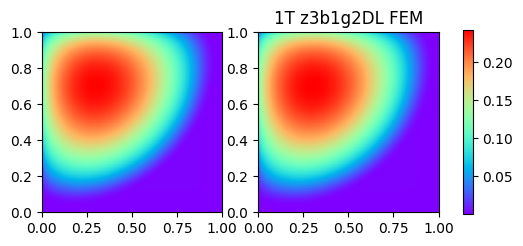

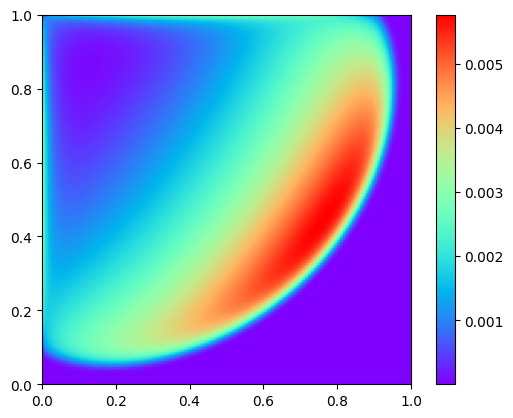

In [27]:
#np.save("/workspace/yzn/radiation diffusion/FiPy/Heat-z3b1g2Dl-FVM", var_1T.value)
var_heat_z3b1g2Dl_fvm = np.load("/workspace/yzn/radiation diffusion/FiPy/Heat-z3b1g2Dl-FVM.npy")
heat_z3b1g2Dl_fvm = np.reshape(var_heat_z3b1g2Dl_fvm, (128, 128))
var_heat_z3b1g2Dl_fem = np.loadtxt('/workspace/yzn/radiation diffusion/FiPy/heat-1T-diffusion-z3b1g2Dl.txt')
var_heat_z3b1g2Dl_fem = np.reshape(var_heat_z3b1g2Dl_fem[:, -1], (129, 129))
heat_z3b1g2Dl_fem = np.zeros((128, 128))
for i in range(128):
    for j in range(128):
        heat_z3b1g2Dl_fem[i, j] = (var_heat_z3b1g2Dl_fem[i,j] + var_heat_z3b1g2Dl_fem[i+1, j] + var_heat_z3b1g2Dl_fem[i, j+1] + var_heat_z3b1g2Dl_fem[i+1, j+1]) / 4
heat_z3b1g2Dl_rl2 = dde.metrics.l2_relative_error(heat_z3b1g2Dl_fem, heat_z3b1g2Dl_fvm)
print("Heat 1T (z3b1g2Dl) rl2 : {:.4e}".format(heat_z3b1g2Dl_rl2))
 
vmin = min(np.min(heat_z3b1g2Dl_fvm), np.min(heat_z3b1g2Dl_fem))
vmax = max(np.max(heat_z3b1g2Dl_fvm), np.max(heat_z3b1g2Dl_fem))
norm = colors.Normalize(vmin=vmin, vmax=vmax)
 
fig = plt.figure()
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)
a = ax.imshow(heat_z3b1g2Dl_fvm, norm=norm, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('1T z3b1g2DL FVM')
b = bx.imshow(heat_z3b1g2Dl_fem, norm=norm, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('1T z3b1g2DL FEM')
fig.colorbar(a, ax=[ax, bx], shrink=0.5)
plt.show()

error_z3b1g2Dl = np.abs(heat_z3b1g2Dl_fvm - heat_z3b1g2Dl_fem)
plt.imshow(error_z3b1g2Dl, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.colorbar()
plt.show()

Heat 1T (z3b2g1Dl) rl2 : 4.0877e-03


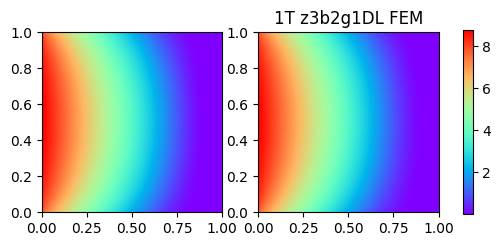

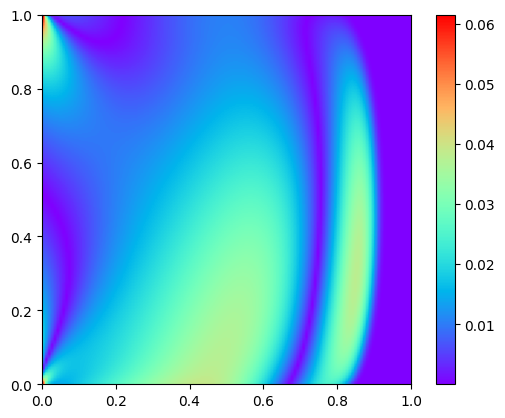

In [19]:
#np.save("/workspace/yzn/radiation diffusion/FiPy/Heat-z3b2g1Dl-FVM", var_1T.value)
var_heat_z3b2g1Dl_fvm = np.load("/workspace/yzn/radiation diffusion/FiPy/Heat-z3b2g1Dl-FVM.npy")
heat_z3b2g1Dl_fvm = np.reshape(var_heat_z3b2g1Dl_fvm, (128, 128))
var_heat_z3b2g1Dl_fem = np.loadtxt('/workspace/yzn/radiation diffusion/FiPy/heat-1T-diffusion-z3b2g1Dl.txt')
var_heat_z3b2g1Dl_fem = np.reshape(var_heat_z3b2g1Dl_fem[:, -1], (129, 129))
heat_z3b2g1Dl_fem = np.zeros((128, 128))
for i in range(128):
    for j in range(128):
        heat_z3b2g1Dl_fem[i, j] = (var_heat_z3b2g1Dl_fem[i,j] + var_heat_z3b2g1Dl_fem[i+1, j] + var_heat_z3b2g1Dl_fem[i, j+1] + var_heat_z3b2g1Dl_fem[i+1, j+1]) / 4
heat_z3b2g1Dl_rl2 = dde.metrics.l2_relative_error(heat_z3b2g1Dl_fem, heat_z3b2g1Dl_fvm)
print("Heat 1T (z3b2g1Dl) rl2 : {:.4e}".format(heat_z3b2g1Dl_rl2))

vmin = min(np.min(heat_z3b2g1Dl_fvm), np.min(heat_z3b2g1Dl_fem))
vmax = max(np.max(heat_z3b2g1Dl_fvm), np.max(heat_z3b2g1Dl_fem))
norm = colors.Normalize(vmin=vmin, vmax=vmax)
 
fig = plt.figure()
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)
a = ax.imshow(heat_z3b2g1Dl_fvm, norm=norm, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('1T z3b2g1DL FVM')
b = bx.imshow(heat_z3b2g1Dl_fem, norm=norm, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('1T z3b2g1DL FEM')
fig.colorbar(a, ax=[ax, bx], shrink=0.5)
plt.show()

error_z3b2g1Dl = np.abs(heat_z3b2g1Dl_fvm - heat_z3b2g1Dl_fem)
plt.imshow(error_z3b2g1Dl, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.colorbar()
plt.show()

Heat 1T (z2b1g2Dl) rl2 : 2.3776e-02


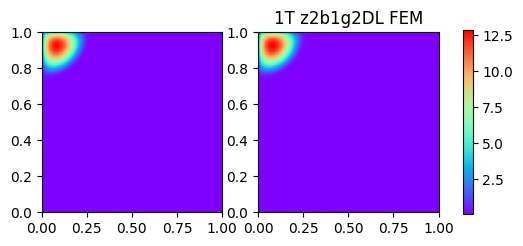

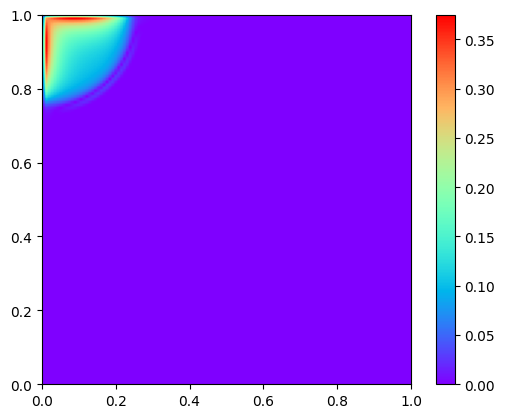

In [8]:
#np.save("/workspace/yzn/radiation diffusion/FiPy/Heat-z2b1g2Dl-FVM", var_1T.value)
var_heat_z2b1g2Dl_fvm = np.load("/workspace/yzn/radiation diffusion/FiPy/Heat-z2b1g2Dl-FVM.npy")
heat_z2b1g2Dl_fvm = np.reshape(var_heat_z2b1g2Dl_fvm, (128, 128))
var_heat_z2b1g2Dl_fem = np.loadtxt('/workspace/yzn/radiation diffusion/FiPy/heat-1T-diffusion-z2b1g2Dl.txt')
var_heat_z2b1g2Dl_fem = np.reshape(var_heat_z2b1g2Dl_fem[:, -1], (129, 129))
heat_z2b1g2Dl_fem = np.zeros((128, 128))
for i in range(128):
    for j in range(128):
        heat_z2b1g2Dl_fem[i, j] = (var_heat_z2b1g2Dl_fem[i,j] + var_heat_z2b1g2Dl_fem[i+1, j] + var_heat_z2b1g2Dl_fem[i, j+1] + var_heat_z2b1g2Dl_fem[i+1, j+1]) / 4
heat_z2b1g2Dl_rl2 = dde.metrics.l2_relative_error(heat_z2b1g2Dl_fem, heat_z2b1g2Dl_fvm)
print("Heat 1T (z2b1g2Dl) rl2 : {:.4e}".format(heat_z2b1g2Dl_rl2))
 
vmin = min(np.min(heat_z2b1g2Dl_fvm), np.min(heat_z2b1g2Dl_fem))
vmax = max(np.max(heat_z2b1g2Dl_fvm), np.max(heat_z2b1g2Dl_fem))
norm = colors.Normalize(vmin=vmin, vmax=vmax)
 
fig = plt.figure()
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)
a = ax.imshow(heat_z2b1g2Dl_fvm, norm=norm, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('1T z2b1g2DL FVM')
b = bx.imshow(heat_z2b1g2Dl_fem, norm=norm, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('1T z2b1g2DL FEM')
fig.colorbar(a, ax=[ax, bx], shrink=0.5)
plt.show()

error_z2b1g2Dl = np.abs(heat_z2b1g2Dl_fvm - heat_z2b1g2Dl_fem)
plt.imshow(error_z2b1g2Dl, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.colorbar()
plt.show()

Heat 1T (z2b2g1Dl) rl2 : 2.0508e-02


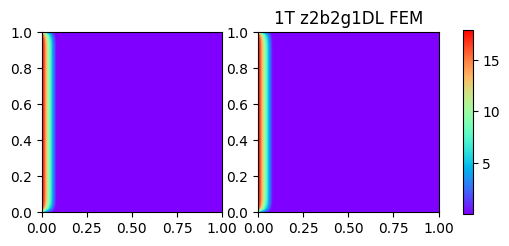

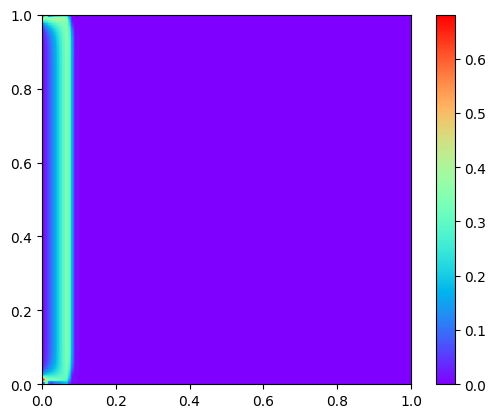

In [51]:
#np.save("/workspace/yzn/radiation diffusion/FiPy/Heat-z2b2g1Dl-FVM", var_1T.value)
var_heat_z2b2g1Dl_fvm = np.load("/workspace/yzn/radiation diffusion/FiPy/Heat-z2b2g1Dl-FVM.npy")
heat_z2b2g1Dl_fvm = np.reshape(var_heat_z2b2g1Dl_fvm, (128, 128))
var_heat_z2b2g1Dl_fem = np.loadtxt('/workspace/yzn/radiation diffusion/FiPy/heat-1T-diffusion-z2b2g1Dl.txt')
var_heat_z2b2g1Dl_fem = np.reshape(var_heat_z2b2g1Dl_fem[:, -1], (129, 129))
heat_z2b2g1Dl_fem = np.zeros((128, 128))
for i in range(128):
    for j in range(128):
        heat_z2b2g1Dl_fem[i, j] = (var_heat_z2b2g1Dl_fem[i,j] + var_heat_z2b2g1Dl_fem[i+1, j] + var_heat_z2b2g1Dl_fem[i, j+1] + var_heat_z2b2g1Dl_fem[i+1, j+1]) / 4
heat_z2b2g1Dl_rl2 = dde.metrics.l2_relative_error(heat_z2b2g1Dl_fem, heat_z2b2g1Dl_fvm)
print("Heat 1T (z2b2g1Dl) rl2 : {:.4e}".format(heat_z2b2g1Dl_rl2))

vmin = min(np.min(heat_z2b2g1Dl_fvm), np.min(heat_z2b2g1Dl_fem))
vmax = max(np.max(heat_z2b2g1Dl_fvm), np.max(heat_z2b2g1Dl_fem))
norm = colors.Normalize(vmin=vmin, vmax=vmax)
 
fig = plt.figure()
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)
a = ax.imshow(heat_z2b2g1Dl_fvm, norm=norm, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('1T z2b2g1DL FVM')
b = bx.imshow(heat_z2b2g1Dl_fem, norm=norm, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('1T z2b2g1DL FEM')
fig.colorbar(a, ax=[ax, bx], shrink=0.5)
plt.show()

error_z2b2g1Dl = np.abs(heat_z2b2g1Dl_fvm - heat_z2b2g1Dl_fem)
plt.imshow(error_z2b2g1Dl, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.colorbar()
plt.show()

Heat 1T (z1b1g2Dl) rl2 : 5.9580e-02


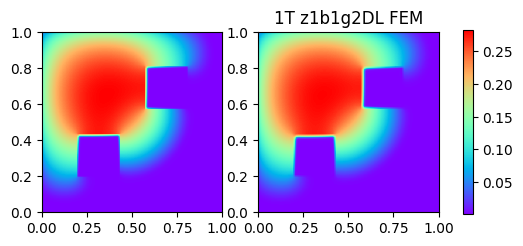

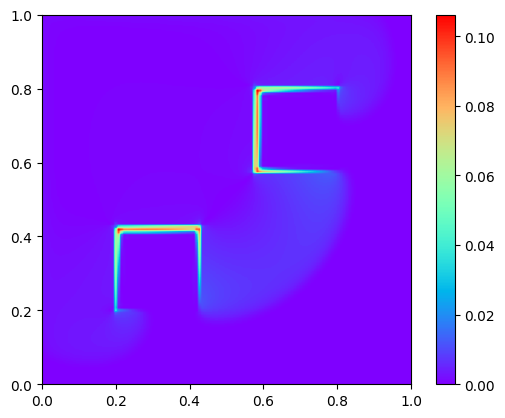

In [20]:
#np.save("/workspace/yzn/radiation diffusion/FiPy/Heat-z1b1g2Dl-FVM", var_1T.value)
var_heat_z1b1g2Dl_fvm = np.load("/workspace/yzn/radiation diffusion/FiPy/Heat-z1b1g2Dl-FVM.npy")
heat_z1b1g2Dl_fvm = np.reshape(var_heat_z1b1g2Dl_fvm, (128, 128))
var_heat_z1b1g2Dl_fem = np.loadtxt('/workspace/yzn/radiation diffusion/FiPy/heat-1T-diffusion-z1b1g2Dl.txt')
var_heat_z1b1g2Dl_fem = np.reshape(var_heat_z1b1g2Dl_fem[:, -1], (129, 129))
heat_z1b1g2Dl_fem = np.zeros((128, 128))
for i in range(128):
    for j in range(128):
        heat_z1b1g2Dl_fem[i, j] = (var_heat_z1b1g2Dl_fem[i,j] + var_heat_z1b1g2Dl_fem[i+1, j] + var_heat_z1b1g2Dl_fem[i, j+1] + var_heat_z1b1g2Dl_fem[i+1, j+1]) / 4
heat_z1b1g2Dl_rl2 = dde.metrics.l2_relative_error(heat_z1b1g2Dl_fem, heat_z1b1g2Dl_fvm)
print("Heat 1T (z1b1g2Dl) rl2 : {:.4e}".format(heat_z1b1g2Dl_rl2))
 
vmin = min(np.min(heat_z1b1g2Dl_fvm), np.min(heat_z1b1g2Dl_fem))
vmax = max(np.max(heat_z1b1g2Dl_fvm), np.max(heat_z1b1g2Dl_fem))
norm = colors.Normalize(vmin=vmin, vmax=vmax)
 
fig = plt.figure()
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)
a = ax.imshow(heat_z1b1g2Dl_fvm, norm=norm, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('1T z1b1g2DL FVM')
b = bx.imshow(heat_z1b1g2Dl_fem, norm=norm, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('1T z1b1g2DL FEM')
fig.colorbar(a, ax=[ax, bx], shrink=0.5)
plt.show()

error_z1b1g2Dl = np.abs(heat_z1b1g2Dl_fvm - heat_z1b1g2Dl_fem)
plt.imshow(error_z1b1g2Dl, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.colorbar()
plt.show()

Heat 1T (z1b2g1Dl) rl2 : 2.8553e-02


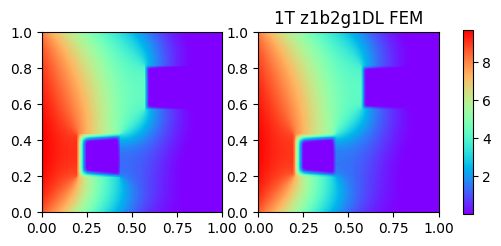

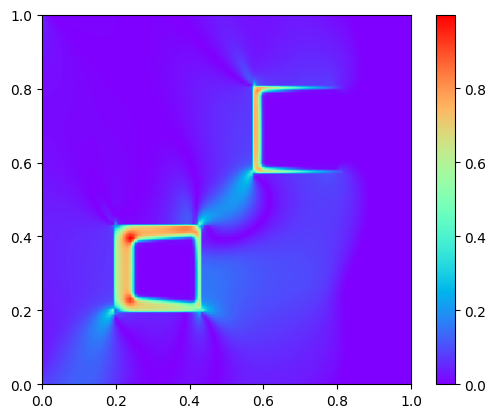

In [44]:
#np.save("/workspace/yzn/radiation diffusion/FiPy/Heat-z1b2g1Dl-FVM", var_1T.value)
var_heat_z1b2g1Dl_fvm = np.load("/workspace/yzn/radiation diffusion/FiPy/Heat-z1b2g1Dl-FVM.npy")
heat_z1b2g1Dl_fvm = np.reshape(var_heat_z1b2g1Dl_fvm, (128, 128))
var_heat_z1b2g1Dl_fem = np.loadtxt('/workspace/yzn/radiation diffusion/FiPy/heat-1T-diffusion-z1b2g1Dl.txt')
var_heat_z1b2g1Dl_fem = np.reshape(var_heat_z1b2g1Dl_fem[:, -1], (129, 129))
heat_z1b2g1Dl_fem = np.zeros((128, 128))
for i in range(128):
    for j in range(128):
        heat_z1b2g1Dl_fem[i, j] = (var_heat_z1b2g1Dl_fem[i,j] + var_heat_z1b2g1Dl_fem[i+1, j] + var_heat_z1b2g1Dl_fem[i, j+1] + var_heat_z1b2g1Dl_fem[i+1, j+1]) / 4
heat_z1b2g1Dl_rl2 = dde.metrics.l2_relative_error(heat_z1b2g1Dl_fem, heat_z1b2g1Dl_fvm)
print("Heat 1T (z1b2g1Dl) rl2 : {:.4e}".format(heat_z1b2g1Dl_rl2))

vmin = min(np.min(heat_z1b2g1Dl_fvm), np.min(heat_z1b2g1Dl_fem))
vmax = max(np.max(heat_z1b2g1Dl_fvm), np.max(heat_z1b2g1Dl_fem))
norm = colors.Normalize(vmin=vmin, vmax=vmax)
 
fig = plt.figure()
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)
a = ax.imshow(heat_z1b2g1Dl_fvm, norm=norm, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('1T z1b2g1DL FVM')
b = bx.imshow(heat_z1b2g1Dl_fem, norm=norm, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('1T z1b2g1DL FEM')
fig.colorbar(a, ax=[ax, bx], shrink=0.5)
plt.show()

error_z1b2g1Dl = np.abs(heat_z1b2g1Dl_fvm - heat_z1b2g1Dl_fem)
plt.imshow(error_z1b2g1Dl, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.colorbar()
plt.show()

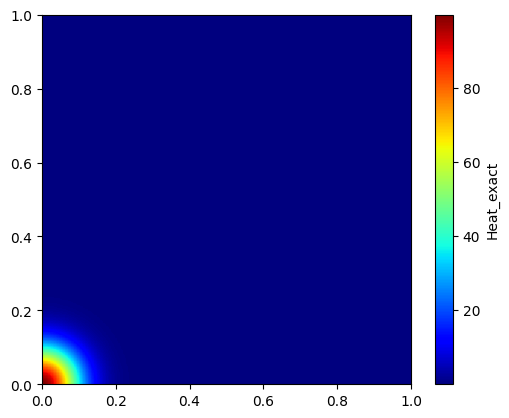

<Figure size 640x480 with 0 Axes>

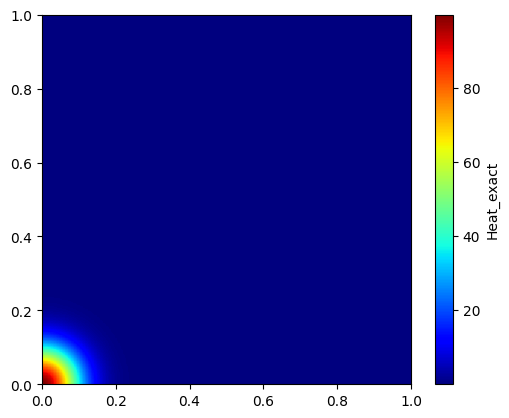

In [10]:
x, y = mesh.cellCenters
initial_heat = 0.001 + 100 * numerix.exp(-(x**2 + y**2)/0.01)
var_heat = CellVariable(name = "Heat_exact",
                   mesh = mesh,
                   value = initial_heat)
var_heat.faceGrad.constrain(0 * mesh.faceNormals, where=mesh.exteriorFaces)
eq_heat = TransientTerm() == DiffusionTerm(coeff=D)
if __name__ == '__main__':
    viewer = Viewer(vars=var_heat)
    viewer.plot()

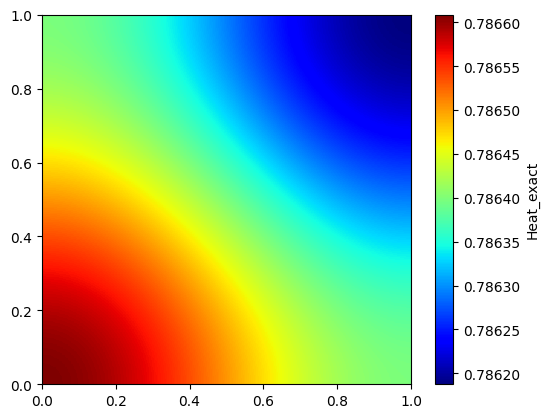

In [11]:
for step in range(steps):    
    eq_heat.solve(var=var_heat,
             dt=timeStepDuration)
    if __name__ == '__main__':
        #viewer = Viewer(vars=var_heat, title=f'{(step+1)*timeStepDuration:.2f}')
        viewer.plot()

Heat Case1 rl2 : 6.4636e-04


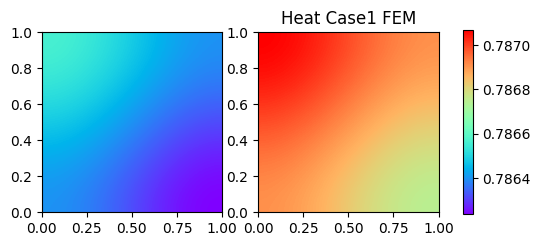

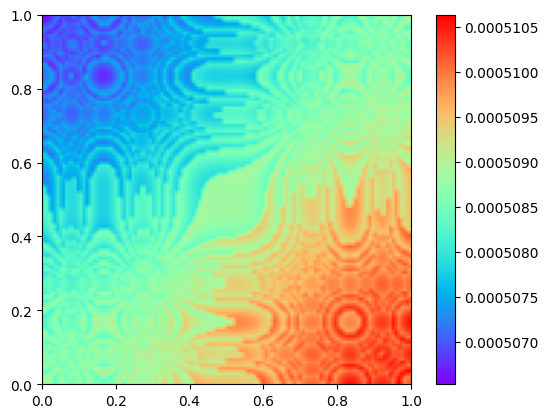

In [15]:
#np.save("/workspace/yzn/radiation diffusion/FiPy/Heat-simple-FVM", var_heat.value)
var_heat_fvm = np.load("/workspace/yzn/radiation diffusion/FiPy/Heat-simple-FVM.npy")
heat_fvm = np.reshape(var_heat_fvm, (128, 128))
var_heat_fem = np.loadtxt('/workspace/yzn/radiation diffusion/FiPy/Heat-simple.txt')
var_heat_fem = np.reshape(var_heat_fem[:, -1], (129, 129))
heat_fem = np.zeros((128, 128))
for i in range(128):
    for j in range(128):
        heat_fem[i, j] = (var_heat_fem[i,j] + var_heat_fem[i+1, j] + var_heat_fem[i, j+1] + var_heat_fem[i+1, j+1]) / 4
heat_rl2 = dde.metrics.l2_relative_error(heat_fem, heat_fvm)
print("Heat Case1 rl2 : {:.4e}".format(heat_rl2))

vmin = min(np.min(heat_fvm), np.min(heat_fem))
vmax = max(np.max(heat_fvm), np.max(heat_fem))
norm = colors.Normalize(vmin=vmin, vmax=vmax)
 
fig = plt.figure()
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)
a = ax.imshow(heat_fvm, norm=norm, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('Heat Case1 FVM')
b = bx.imshow(heat_fem, norm=norm, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('Heat Case1 FEM')
fig.colorbar(a, ax=[ax, bx], shrink=0.5)
plt.show()

error_heat = np.abs(heat_fvm - heat_fem)
plt.imshow(error_heat, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.colorbar()
plt.show()